## Install TensorTrade

In [1]:
!python3 -m pip install -e .. -U

Obtaining file:///Users/adam/Desktop/Capfolio/tensortrade
  Attempting uninstall: tensortrade
    Found existing installation: TensorTrade 0.2.0b0
    Uninstalling TensorTrade-0.2.0b0:
      Successfully uninstalled TensorTrade-0.2.0b0
  Running setup.py develop for tensortrade


## Setup Data Fetching

In [2]:
import ssl
import pandas as pd

ssl._create_default_https_context = ssl._create_unverified_context # Only used if pandas gives a SSLError

def fetch(exchange_name, symbol, timeframe):
    url = "https://www.cryptodatadownload.com/cdd/"
    filename = "{}_{}USD_{}.csv".format(exchange_name, symbol, timeframe)
    volume_column = "Volume {}".format(symbol)
    new_volume_column = "Volume_{}".format(symbol)
    
    df = pd.read_csv(url + filename, skiprows=1)
    df = df[::-1]
    df = df.drop(["Symbol"], axis=1)
    df = df.rename({"Volume USD": "volume", volume_column: new_volume_column}, axis=1)
    df = df.set_index("Date")
    df.columns = [symbol + ":" + name.lower() for name in df.columns]
                     
    return df

## Setup Trading Environment

In [3]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, DataFeed, Module
from tensortrade.instruments import USD, BTC, ETH, LTC
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.environments import TradingEnvironment

coinbase_data = pd.concat([
    fetch("Coinbase", "BTC", "1h"),
    fetch("Coinbase", "ETH", "1h")
], axis=1)

coinbase = Exchange("coinbase", service=execute_order)(
    Stream("USD-BTC", list(coinbase_data['BTC:close'])),
    Stream("USD-ETH", list(coinbase_data['ETH:close']))
)

coinbase_btc = coinbase_data.loc[:, [name.startswith("BTC") for name in coinbase_data.columns]]

with Module("coinbase") as coinbase_ns:
    nodes = [Stream(name, list(coinbase_data[name])) for name in coinbase_data.columns]

feed = DataFeed([coinbase_ns])

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 10 * BTC),
    Wallet(coinbase, 5 * ETH),
])

env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20
)

## Example Data Feed Observation

In [4]:
env.feed.next()

{'coinbase:/USD:/total': 10000,
 'coinbase:/BTC:high': 2513.38,
 'coinbase:/BTC:/free': 10,
 'coinbase:/BTC:low': 2495.12,
 'coinbase:/USD:/free': 10000,
 'coinbase:/BTC:/locked': 0,
 'coinbase:/BTC:close': 2509.17,
 'coinbase:/BTC:volume_btc': 114.6,
 'coinbase:/BTC:/total': 10,
 'coinbase:/ETH:close': 275.01,
 'coinbase:/USD-BTC': 2509.17,
 'coinbase:/BTC:/worth': 25091.7,
 'coinbase:/BTC:volume': 287000.32,
 'coinbase:/ETH:open': 279.98,
 'coinbase:/USD-ETH': 275.01,
 'coinbase:/BTC:open': 2505.56,
 'coinbase:/ETH:high': 279.99,
 'coinbase:/ETH:low': 272.1,
 'coinbase:/ETH:/locked': 0,
 'coinbase:/ETH:/free': 5,
 'coinbase:/ETH:volume_eth': 2455.28,
 'coinbase:/ETH:/total': 5,
 'coinbase:/USD:/locked': 0,
 'coinbase:/ETH:volume': 679358.87,
 'coinbase:/ETH:/worth': 1375.05,
 'net_worth': 36466.75}

## Setup and Train DQN Agent

In [5]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)

agent.train(n_steps=200, save_path="examples/agents/")

====      EPISODE ID: eb726f14-9b6a-46be-a069-c79b007ff909      ====


## Plot Performance

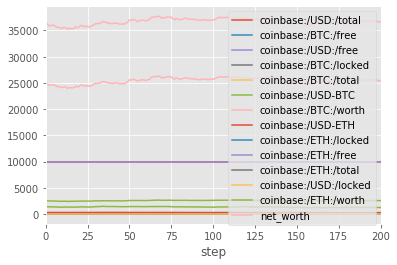

In [6]:
%matplotlib inline

portfolio.performance.plot()

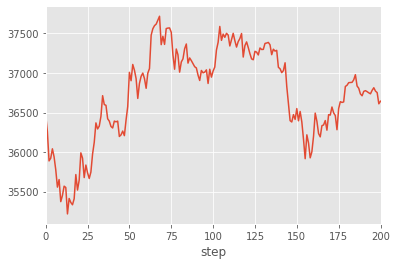

In [7]:
portfolio.performance.net_worth.plot()

## Setup and Train A2C Agent

In [8]:
from tensortrade.agents import A2CAgent

agent = A2CAgent(env)

agent.train(n_steps=200, save_path="examples/agents/")

====      EPISODE ID: 75731cea-092a-4475-8f6c-b787343bfbd9      ====


InvalidArgumentError: Can not squeeze dim[1], expected a dimension of 1, got 128 [Op:Squeeze]

In [ ]:
portfolio.performance.plot()

In [ ]:
portfolio.performance.net_worth.plot()

## Setup and Train Parallel DQN Agent

In [9]:
from tensortrade.agents import ParallelDQNAgent

def create_env():
    feed = DataFeed([coinbase_ns])

    portfolio = Portfolio(USD, [
        Wallet(coinbase, 10000 * USD),
        Wallet(coinbase, 10 * BTC),
        Wallet(coinbase, 5 * ETH),
    ])
    
    env = TradingEnvironment(
        feed=feed,
        portfolio=portfolio,
        action_scheme='managed-risk',
        reward_scheme='risk-adjusted',
        window_size=20
    )
    
    return env

agent = ParallelDQNAgent(create_env)

agent.train(n_envs=4, n_steps=200, save_path="examples/agents/")

====      EPISODE ID (0/2147483647): 0a15a273-c1e9-4f8e-9a50-6ea95795b484      ====
====      EPISODE ID (0/2147483647): d311dbdc-33d7-4704-b394-9468481e8c68      ====
====      EPISODE ID (0/2147483647): 9bca0f01-925f-4e73-86eb-c91ba8f9d20c      ====
====      EPISODE ID (0/2147483647): 3d12e8dd-674e-45c9-9009-59ab235342af      ====
